In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# 1. 数据加载与处理
def create_data(data_dir):
    image_paths = []
    mask_paths = []

    # 设置图片和掩码文件夹的路径
    image_dir = os.path.join(data_dir, 'JPEGImages')
    mask_dir = os.path.join(data_dir, 'SegmentationClass')

    # 获取所有图像文件名，假设图像文件名与掩码文件名一致
    image_files = sorted(os.listdir(image_dir))

    for image_name in image_files:
        # 获取图像路径
        image_path = os.path.join(image_dir, image_name)

        # 构造对应的掩码路径
        mask_name = os.path.splitext(image_name)[0] + ".png"  # 假设掩码文件是.png格式
        mask_path = os.path.join(mask_dir, mask_name)

        # 检查掩码文件是否存在
        if os.path.exists(mask_path):
            image_paths.append(image_path)
            mask_paths.append(mask_path)
        else:
            print(f"Warning: Mask file for {image_name} not found, skipping this image.")

    return image_paths, mask_paths


# 读取并处理图像
def load_image(image, SIZE):
    return np.round(tf.image.resize(img_to_array(load_img(image)) / 255., (SIZE, SIZE)), 4)


# 读取多个图像
def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img

    return images





In [3]:
# 2. 定义SINet模型
def SINet(input_size):
    inputs = layers.Input(shape=input_size)

    # Encoder part
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Decoder part
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs)
    return model

In [4]:
# 3. 加载数据
SIZE = 256
data_dir = r'D:\training_set'  # 替换为你的数据集路径
image_paths, mask_paths = create_data(data_dir)

# 加载图像和掩码
imgs = load_images(image_paths, SIZE)
msks = load_images(mask_paths, SIZE, mask=True)


In [5]:
# 4. 划分训练集和测试集
indices = np.random.permutation(len(imgs))
size = int(len(imgs) * 0.8)

x_train = imgs[indices[:size]]
y_train = msks[indices[:size]]
x_test = imgs[indices[size:]]
y_test = msks[indices[size:]]


In [7]:
# 5. 编译并训练模型
model = SINet(input_size=(SIZE, SIZE, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(x_train, y_train, batch_size=8, epochs=10, validation_split=0.2)



Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 608ms/step - accuracy: 0.4772 - loss: 0.6763 - val_accuracy: 0.5648 - val_loss: 0.5843
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 617ms/step - accuracy: 0.6012 - loss: 0.5570 - val_accuracy: 0.5648 - val_loss: 0.5499
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 610ms/step - accuracy: 0.5923 - loss: 0.5306 - val_accuracy: 0.5648 - val_loss: 0.5250
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 583ms/step - accuracy: 0.5817 - loss: 0.5064 - val_accuracy: 0.5648 - val_loss: 0.5004
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 572ms/step - accuracy: 0.5889 - loss: 0.4742 - val_accuracy: 0.5648 - val_loss: 0.4903
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 615ms/step - accuracy: 0.5869 - loss: 0.4670 - val_accuracy: 0.5648 - val_loss: 0.4901
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 649ms/step - accuracy: 0.5956 - loss: 0.4597 - val_accuracy: 0.5648 - val_loss: 0.4855
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 616ms/step - accuracy: 0.5894 - loss: 0.4596 - val_accu

In [14]:
model.save('sinet_model.h5')


In [9]:
# 6. 评估模型
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 501ms/step - accuracy: 0.5832 - loss: 0.4571
Test Loss: 0.4554493725299835
Test Accuracy: 0.5854039192199707


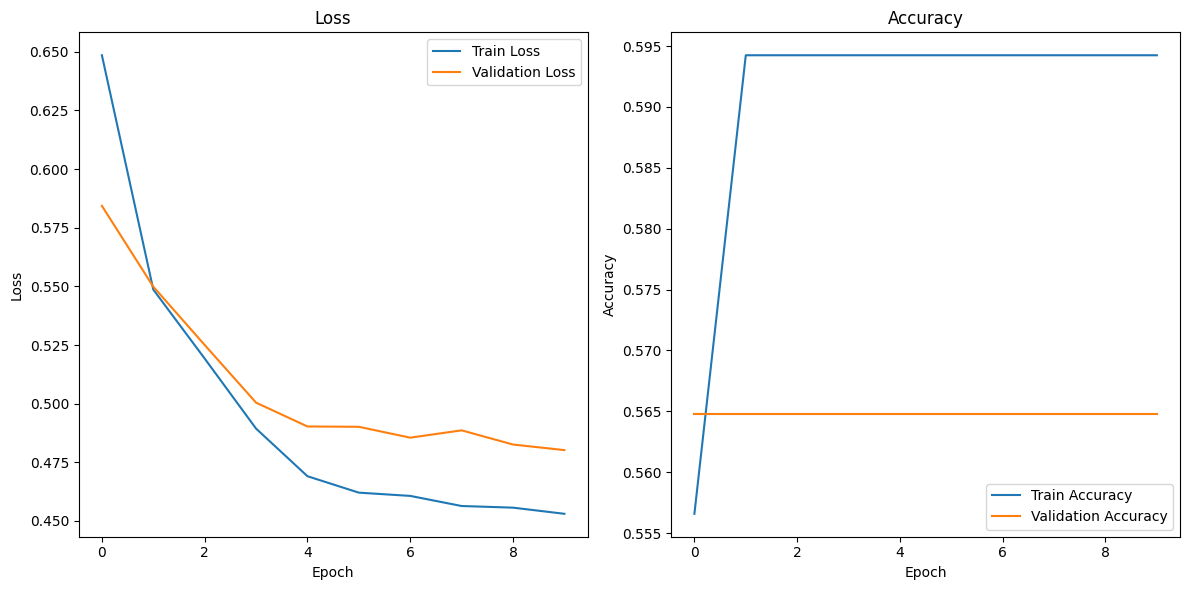

In [10]:
# 7. 可视化训练过程（损失和准确率）
plt.figure(figsize=(12, 6))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step


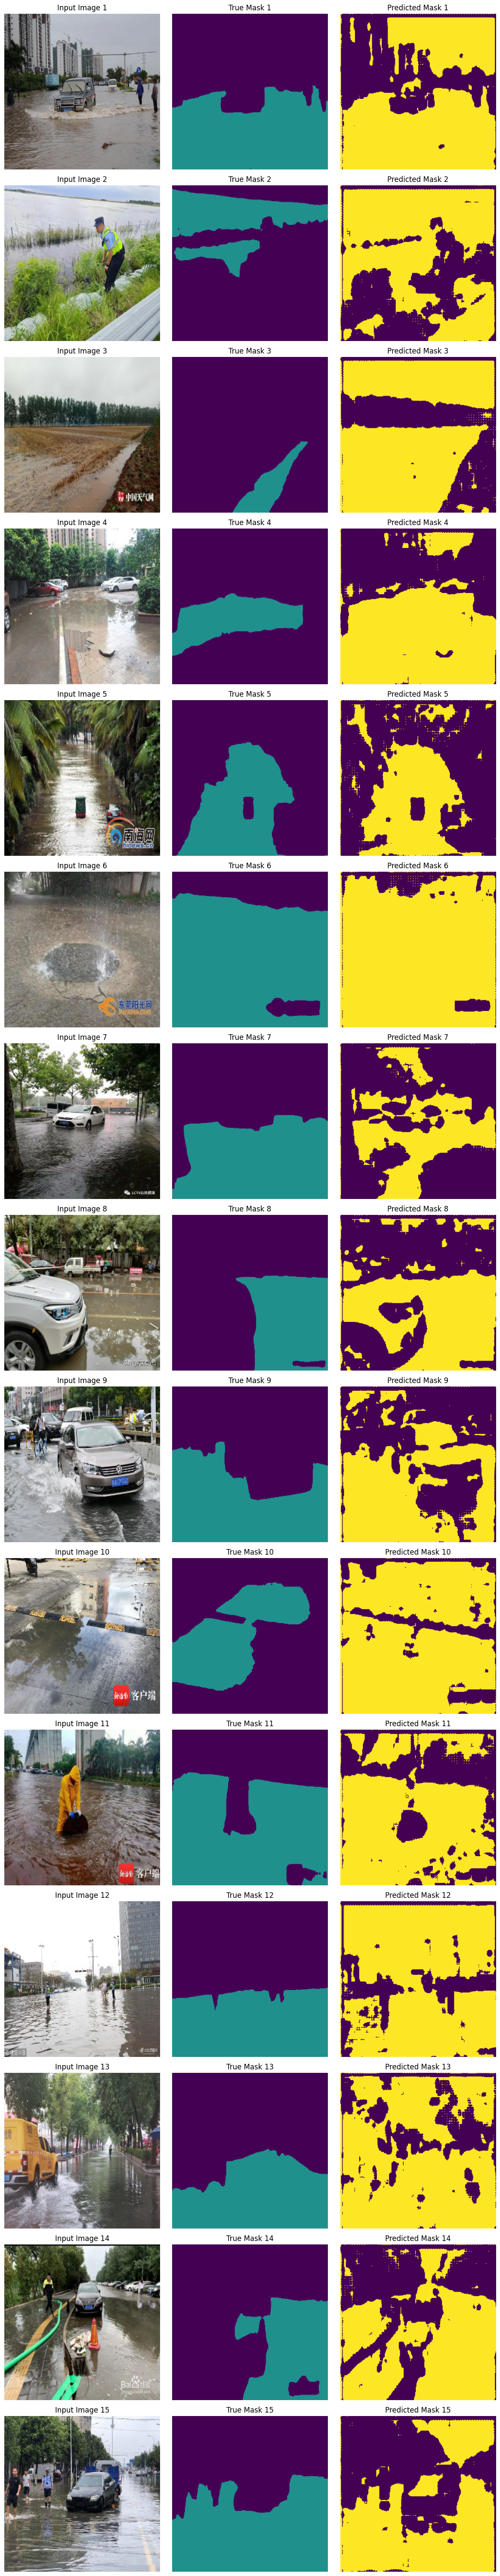

In [13]:
# 预测整个测试集
predictions = model.predict(x_test)
def get_colored_mask(mask):
    colormap = plt.get_cmap('viridis')  
    colored_mask = colormap(mask.squeeze())
    return colored_mask
# 随机选择15个样本的索引
sample_indices = np.random.choice(len(x_test), 15, replace=False)  # 随机选择15个索引
sample_images = x_test[sample_indices]
sample_masks = y_test[sample_indices]
sample_predictions = predictions[sample_indices]

# 将预测结果转化为二值掩码，使用阈值0.3
sample_predictions_binary = (sample_predictions > 0.2).astype(np.float32)

# 绘制多个样本的函数
def plot_samples(images, true_masks, pred_masks):
    num_samples = len(images)
    plt.figure(figsize=(12, 4 * num_samples))
    
    for i in range(num_samples):
        # 输入图像
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.title(f'Input Image {i+1}')
        plt.imshow(images[i])
        plt.axis('off')

        # 真实掩码
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.title(f'True Mask {i+1}')
        colored_mask = get_colored_mask(true_masks[i])  # 使用彩色掩码显示
        plt.imshow(colored_mask)
        plt.axis('off')

        # 预测掩码
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.title(f'Predicted Mask {i+1}')
        colored_mask = get_colored_mask(pred_masks[i])  # 使用彩色掩码显示
        plt.imshow(colored_mask)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 绘制15个样本的输入图像、真实掩码和预测掩码
plot_samples(sample_images, sample_masks, sample_predictions_binary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


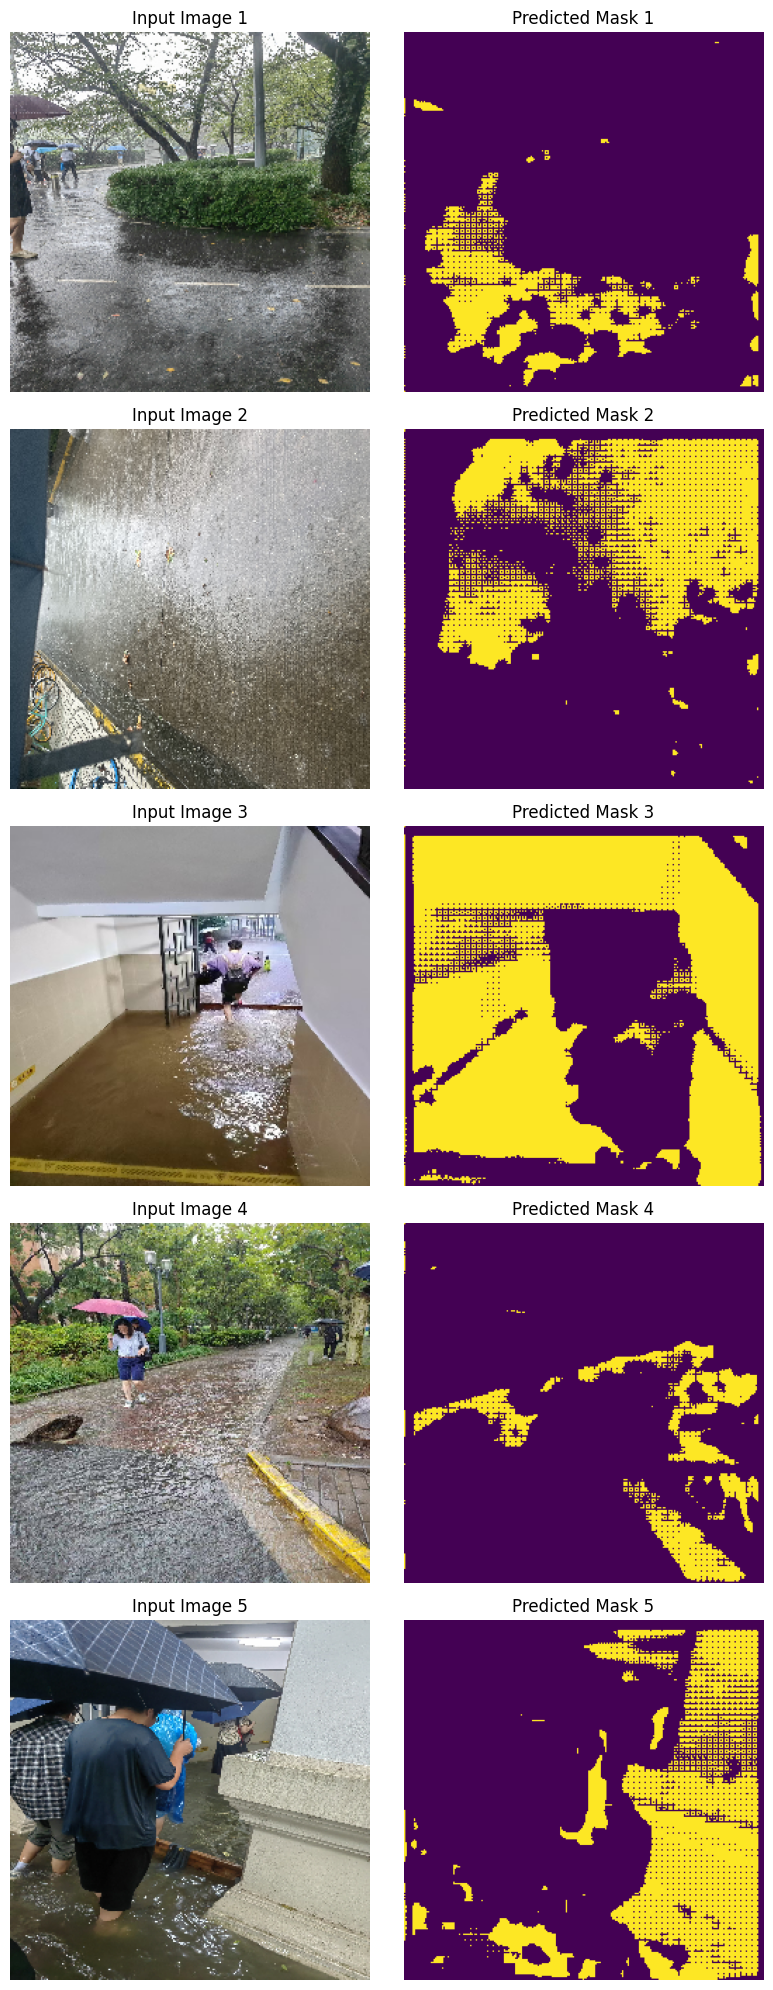

In [16]:

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# 1. 加载图片文件夹中的图片
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if filename.endswith(".png") or filename.endswith(".jpg"):  # 根据文件类型过滤
            img = image.load_img(img_path, target_size=(256, 256))  # 适配目标尺寸
            img_array = image.img_to_array(img) / 255.0  # 归一化处理
            images.append(img_array)
    return np.array(images)

# 2. 加载您的模型
# 请根据您的模型保存路径修改
model = load_model('sinet_model.h5')

# 3. 加载自己的图片（文件夹路径）
folder_path = r'C:\Users\ASUS\Desktop\test'  # 替换为实际的文件夹路径
images = load_images_from_folder(folder_path)

# 4. 进行预测
predictions = model.predict(images)

# 5. 转化为二值掩码
predictions_binary = (predictions > 0.3).astype(np.float32)  # 根据需要调整阈值

# 6. 彩色掩码转换函数
def get_colored_mask(mask):
    colormap = plt.get_cmap('viridis')  
    colored_mask = colormap(mask.squeeze())
    return colored_mask

# 7. 绘制多个样本的函数
def plot_samples(images, pred_masks):
    num_samples = len(images)
    plt.figure(figsize=(12, 4 * num_samples))
    
    for i in range(num_samples):
        # 输入图像
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.title(f'Input Image {i+1}')
        plt.imshow(images[i])
        plt.axis('off')

        # 预测掩码
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.title(f'Predicted Mask {i+1}')
        colored_mask = get_colored_mask(pred_masks[i])  # 使用彩色掩码显示
        plt.imshow(colored_mask)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 8. 绘制原图和预测掩码的对比
plot_samples(images, predictions_binary)
